In [42]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge , Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error , classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [43]:
df = pd.read_csv("final_data.csv")

In [44]:
df['Risk'].value_counts(normalize=True)

Risk
1    0.608677
0    0.391323
Name: proportion, dtype: float64

Training Using Linear Regression MultiModel

In [45]:
features_to_scale = ['Age', 'CGPA', 'Semester_Credit_Load']

base_features = [
    'Age', 'Gender', 'CGPA', 'Sleep_Quality', 'Physical_Activity', 
    'Diet_Quality', 'Social_Support', 'Substance_Use', 
    'Counseling_Service_Use', 'Family_History', 'Chronic_Illness', 
    'Financial_Stress', 'Extracurricular_Involvement', 
    'Semester_Credit_Load',
    'Residence_Type_Off-Campus', 'Residence_Type_On-Campus', 
    'Residence_Type_With Family',
    'Relationship_Status_In a Relationship', 
    'Relationship_Status_Married', 'Relationship_Status_Single',
    'Course_Business', 'Course_Computer Science', 'Course_Engineering', 
    'Course_Law', 'Course_Medical', 'Course_Others'
]

risk_features = base_features + ['Pred_Stress', 'Pred_Anxiety', 'Pred_Depression']

In [46]:
df_processed = df.copy()
train_df, test_df = train_test_split(df_processed, test_size=0.2, random_state=42)

In [47]:
scaler = StandardScaler()
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

In [48]:
X_train_base = train_df[base_features]
y_train_stress = train_df['Stress_Level']
y_train_anxiety = train_df['Anxiety_Score']
y_train_depression = train_df['Depression_Score']

In [49]:
stress_model = LinearRegression()
anxiety_model = LinearRegression()
depression_model = LinearRegression()

stress_model.fit(X_train_base, y_train_stress)
anxiety_model.fit(X_train_base, y_train_anxiety)
depression_model.fit(X_train_base, y_train_depression)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [50]:
train_df['Pred_Stress'] = stress_model.predict(X_train_base)
train_df['Pred_Anxiety'] = anxiety_model.predict(X_train_base)
train_df['Pred_Depression'] = depression_model.predict(X_train_base)

In [51]:
X_train_risk = train_df[risk_features]
y_train_risk = train_df['Risk']

risk_model = LinearRegression()
risk_model.fit(X_train_risk, y_train_risk)

train_df['Pred_Risk'] = risk_model.predict(X_train_risk)

In [52]:
X_test_base = test_df[base_features]

test_df['Pred_Stress'] = stress_model.predict(X_test_base)
test_df['Pred_Anxiety'] = anxiety_model.predict(X_test_base)
test_df['Pred_Depression'] = depression_model.predict(X_test_base)

X_test_risk = test_df[risk_features]
test_df['Pred_Risk'] = risk_model.predict(X_test_risk)

In [53]:
threshold = 0.5

test_df['Risk_Binary'] = (test_df['Risk'] > threshold).astype(int)
test_df['Pred_Risk_Binary'] = (test_df['Pred_Risk'] > threshold).astype(int)

In [54]:
print(f"Accuracy: {accuracy_score(test_df['Risk_Binary'], test_df['Pred_Risk_Binary']):.4f}")
print(classification_report(test_df['Risk_Binary'], test_df['Pred_Risk_Binary'], 
                          target_names=['Not At Risk', 'At Risk']))

Accuracy: 0.6291
              precision    recall  f1-score   support

 Not At Risk       0.54      0.30      0.39       544
     At Risk       0.65      0.84      0.73       858

    accuracy                           0.63      1402
   macro avg       0.60      0.57      0.56      1402
weighted avg       0.61      0.63      0.60      1402



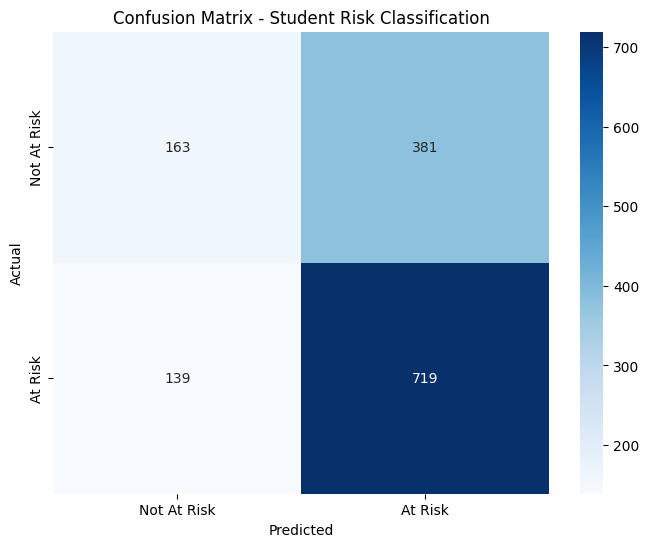

In [55]:
cm = confusion_matrix(test_df['Risk_Binary'], test_df['Pred_Risk_Binary'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not At Risk', 'At Risk'],
            yticklabels=['Not At Risk', 'At Risk'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Student Risk Classification')
plt.show()

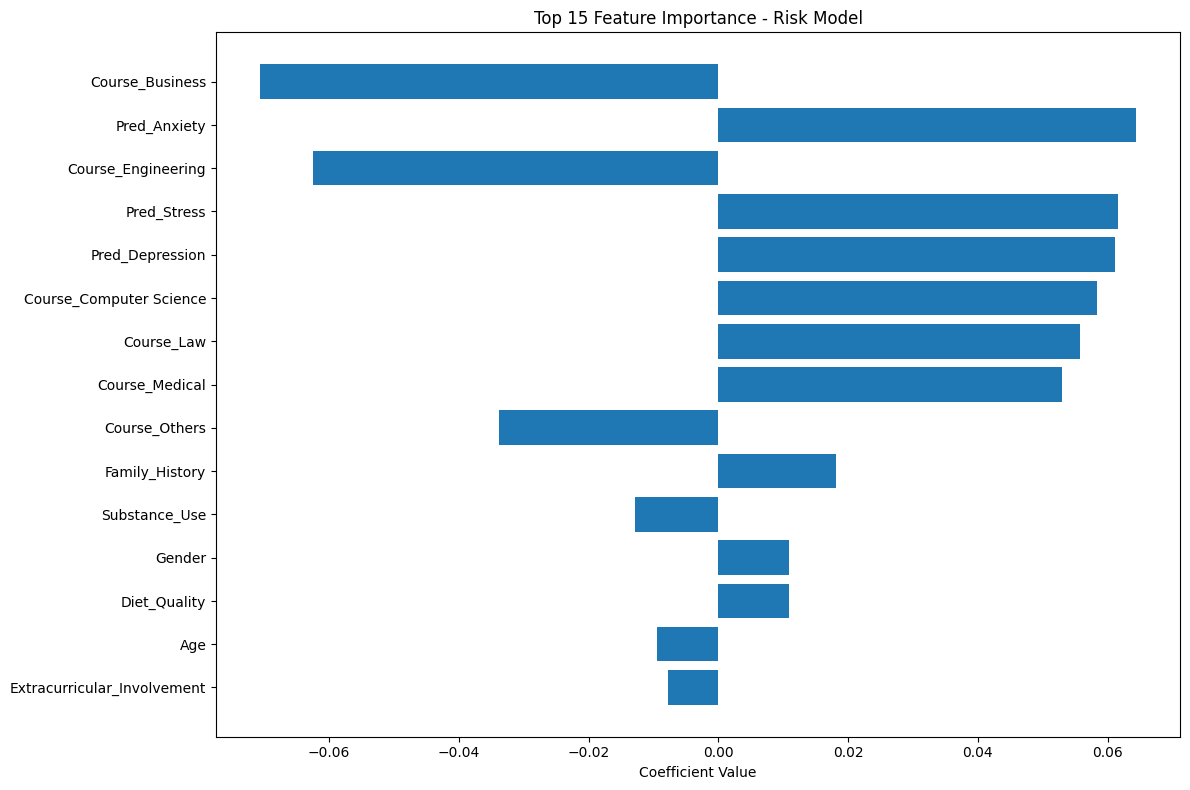

In [56]:
feature_importance = pd.DataFrame({
    'Feature': risk_features,
    'Coefficient': risk_model.coef_
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Importance - Risk Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [57]:
stress_mse = mean_squared_error(test_df['Stress_Level'], test_df['Pred_Stress'])
stress_r2 = r2_score(test_df['Stress_Level'], test_df['Pred_Stress'])
stress_mae = mean_absolute_error(test_df['Stress_Level'], test_df['Pred_Stress'])

anxiety_mse = mean_squared_error(test_df['Anxiety_Score'], test_df['Pred_Anxiety'])
anxiety_r2 = r2_score(test_df['Anxiety_Score'], test_df['Pred_Anxiety'])
anxiety_mae = mean_absolute_error(test_df['Anxiety_Score'], test_df['Pred_Anxiety'])

depression_mse = mean_squared_error(test_df['Depression_Score'], test_df['Pred_Depression'])
depression_r2 = r2_score(test_df['Depression_Score'], test_df['Pred_Depression'])
depression_mae = mean_absolute_error(test_df['Depression_Score'], test_df['Pred_Depression'])

risk_mse = mean_squared_error(test_df['Risk'], test_df['Pred_Risk'])
risk_r2 = r2_score(test_df['Risk'], test_df['Pred_Risk'])
risk_mae = mean_absolute_error(test_df['Risk'], test_df['Pred_Risk'])

metrics_df = pd.DataFrame({
    'Model': ['Stress', 'Anxiety', 'Depression', 'Risk'],
    'MSE': [stress_mse, anxiety_mse, depression_mse, risk_mse],
    'R2 Score': [stress_r2, anxiety_r2, depression_r2, risk_r2],
    'MAE': [stress_mae, anxiety_mae, depression_mae, risk_mae]
})

print(metrics_df)

        Model       MSE  R2 Score       MAE
0      Stress  2.303314  0.115764  1.259369
1     Anxiety  2.470813  0.079579  1.335418
2  Depression  2.431432  0.066587  1.295802
3        Risk  0.227573  0.041636  0.457951


Using Polynomial Regression and Ridge Regularization

In [58]:
POLY_DEGREE = 2

In [59]:
df_processed = df.copy()
train_df, test_df = train_test_split(df_processed, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 5605
Test set size: 1402


In [60]:
df_processed = df.copy()
train_df, test_df = train_test_split(df_processed, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 5605
Test set size: 1402


In [61]:
scaler = StandardScaler()
poly = PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)

train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

In [62]:
X_train_base = train_df[base_features]
y_train_stress = train_df['Stress_Level']
y_train_anxiety = train_df['Anxiety_Score']
y_train_depression = train_df['Depression_Score']

In [63]:
X_train_base = train_df[base_features]
y_train_stress = train_df['Stress_Level']
y_train_anxiety = train_df['Anxiety_Score']
y_train_depression = train_df['Depression_Score']

In [64]:
X_train_poly = poly.fit_transform(X_train_base)

stress_model = Ridge(alpha=1.0)
anxiety_model = Ridge(alpha=1.0)
depression_model = Ridge(alpha=1.0)

stress_model.fit(X_train_poly, y_train_stress)
anxiety_model.fit(X_train_poly, y_train_anxiety)
depression_model.fit(X_train_poly, y_train_depression)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [65]:
train_df['Pred_Stress'] = stress_model.predict(X_train_poly)
train_df['Pred_Anxiety'] = anxiety_model.predict(X_train_poly)
train_df['Pred_Depression'] = depression_model.predict(X_train_poly)

In [66]:
X_train_risk = train_df[risk_features]
y_train_risk = train_df['Risk']

poly_risk = PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)
X_train_risk_poly = poly_risk.fit_transform(X_train_risk)

risk_model = Ridge(alpha=1.0)
risk_model.fit(X_train_risk_poly, y_train_risk)

train_df['Pred_Risk'] = risk_model.predict(X_train_risk_poly)

In [67]:
X_test_base = test_df[base_features]
X_test_poly = poly.transform(X_test_base)

test_df['Pred_Stress'] = stress_model.predict(X_test_poly)
test_df['Pred_Anxiety'] = anxiety_model.predict(X_test_poly)
test_df['Pred_Depression'] = depression_model.predict(X_test_poly)

X_test_risk = test_df[risk_features]
X_test_risk_poly = poly_risk.transform(X_test_risk)

test_df['Pred_Risk'] = risk_model.predict(X_test_risk_poly)

In [68]:
threshold = 0.5

test_df['Risk_Binary'] = (test_df['Risk'] > threshold).astype(int)
test_df['Pred_Risk_Binary'] = (test_df['Pred_Risk'] > threshold).astype(int)

print(f"Threshold: {threshold}\n")
print(f"Accuracy: {accuracy_score(test_df['Risk_Binary'], test_df['Pred_Risk_Binary']):.4f}")
print("\nClassification Report:")
print(classification_report(test_df['Risk_Binary'], test_df['Pred_Risk_Binary'], 
                          target_names=['Not At Risk', 'At Risk']))

Threshold: 0.5

Accuracy: 0.6141

Classification Report:
              precision    recall  f1-score   support

 Not At Risk       0.50      0.30      0.38       544
     At Risk       0.65      0.81      0.72       858

    accuracy                           0.61      1402
   macro avg       0.58      0.56      0.55      1402
weighted avg       0.59      0.61      0.59      1402



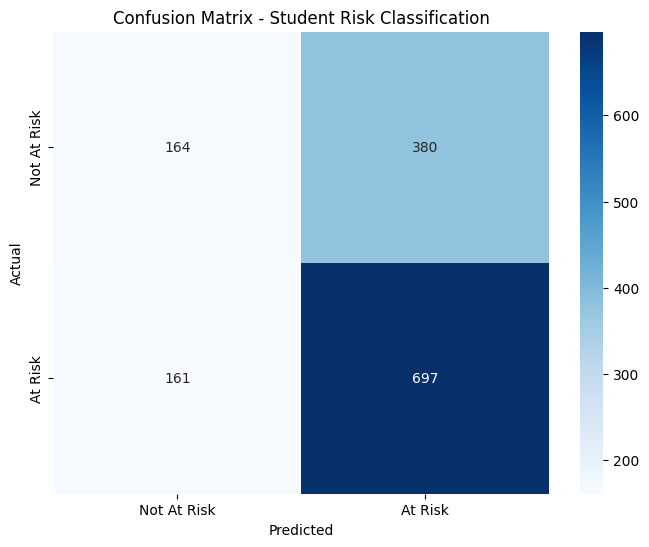

In [69]:
cm = confusion_matrix(test_df['Risk_Binary'], test_df['Pred_Risk_Binary'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not At Risk', 'At Risk'],
            yticklabels=['Not At Risk', 'At Risk'])
plt.ylabel('Actual') 
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Student Risk Classification')
plt.show()

In [70]:
poly_feature_names = poly_risk.get_feature_names_out(risk_features)
feature_importance_poly = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coefficient': risk_model.coef_
})
feature_importance_poly['Abs_Coefficient'] = np.abs(feature_importance_poly['Coefficient'])
feature_importance_poly = feature_importance_poly.sort_values('Abs_Coefficient', ascending=False)

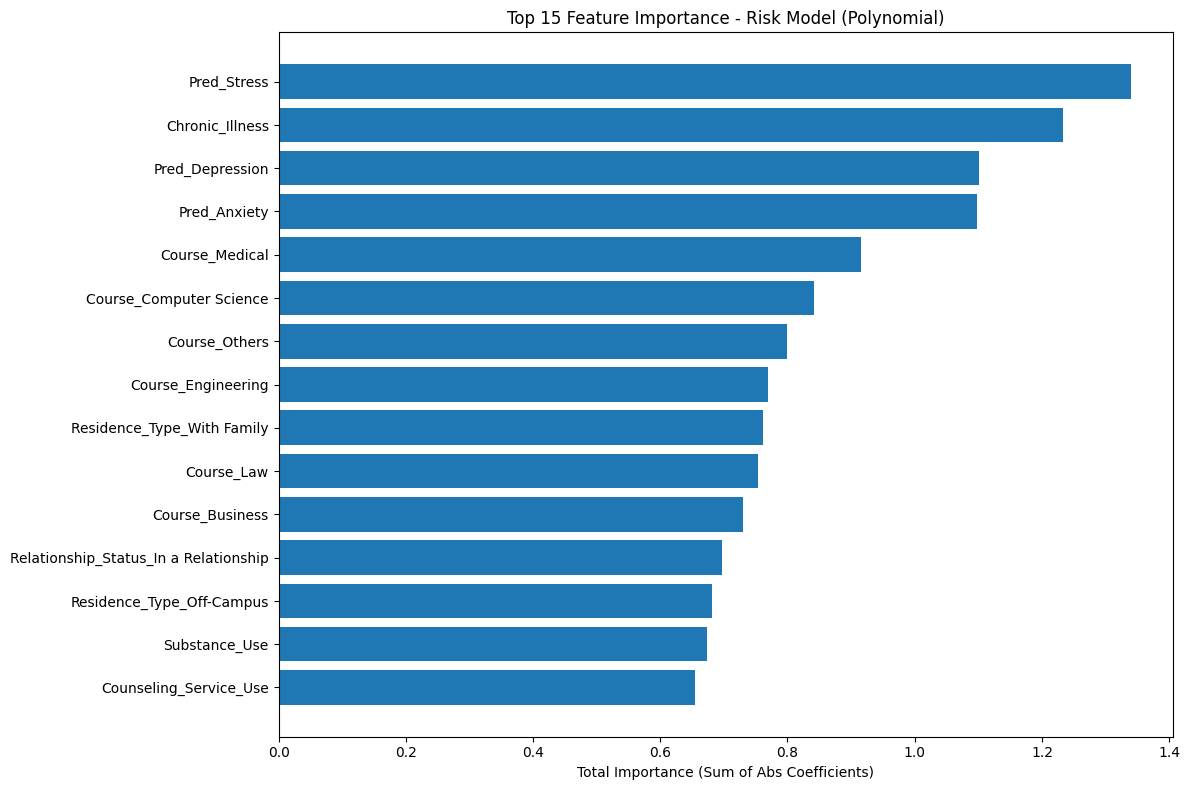

In [71]:
original_importance = {}
for feature in risk_features:
    mask = feature_importance_poly['Feature'].str.contains(feature, regex=False)
    original_importance[feature] = feature_importance_poly.loc[mask, 'Abs_Coefficient'].sum()

original_importance_df = pd.DataFrame({
    'Feature': list(original_importance.keys()),
    'Total_Importance': list(original_importance.values())
}).sort_values('Total_Importance', ascending=False)

plt.figure(figsize=(12, 8))
top_features = original_importance_df.head(15)
plt.barh(top_features['Feature'], top_features['Total_Importance'])
plt.xlabel('Total Importance (Sum of Abs Coefficients)')
plt.title('Top 15 Feature Importance - Risk Model (Polynomial)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Using Polynomial Regression and Lasso Regularization

In [72]:
POLY_DEGREE = 4
df_processed = df.copy()
train_df, test_df = train_test_split(df_processed, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 5605
Test set size: 1402


In [73]:
scaler = StandardScaler()
poly = PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)

train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

In [74]:
X_train_base = train_df[base_features]
y_train_stress = train_df['Stress_Level']
y_train_anxiety = train_df['Anxiety_Score']
y_train_depression = train_df['Depression_Score']

In [75]:
X_train_poly = poly.fit_transform(X_train_base)

stress_model = Lasso(alpha=0.1, max_iter=10000)
anxiety_model = Lasso(alpha=0.1, max_iter=10000)
depression_model = Lasso(alpha=0.1, max_iter=10000)

stress_model.fit(X_train_poly, y_train_stress)
anxiety_model.fit(X_train_poly, y_train_anxiety)
depression_model.fit(X_train_poly, y_train_depression)

,alpha,0.1
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,10000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [76]:
train_df['Pred_Stress'] = stress_model.predict(X_train_poly)
train_df['Pred_Anxiety'] = anxiety_model.predict(X_train_poly)
train_df['Pred_Depression'] = depression_model.predict(X_train_poly)

In [77]:
X_train_risk = train_df[risk_features]
y_train_risk = train_df['Risk']

poly_risk = PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)
X_train_risk_poly = poly_risk.fit_transform(X_train_risk)

risk_model = Lasso(alpha=0.1, max_iter=10000)
risk_model.fit(X_train_risk_poly, y_train_risk)

train_df['Pred_Risk'] = risk_model.predict(X_train_risk_poly)

In [78]:
X_test_base = test_df[base_features]
X_test_poly = poly.transform(X_test_base)

test_df['Pred_Stress'] = stress_model.predict(X_test_poly)
test_df['Pred_Anxiety'] = anxiety_model.predict(X_test_poly)
test_df['Pred_Depression'] = depression_model.predict(X_test_poly)

X_test_risk = test_df[risk_features]
X_test_risk_poly = poly_risk.transform(X_test_risk)

test_df['Pred_Risk'] = risk_model.predict(X_test_risk_poly)

In [79]:
threshold = 0.5

test_df['Risk_Binary'] = (test_df['Risk'] > threshold).astype(int)
test_df['Pred_Risk_Binary'] = (test_df['Pred_Risk'] > threshold).astype(int)

print(f"Threshold: {threshold}\n")
print(f"Accuracy: {accuracy_score(test_df['Risk_Binary'], test_df['Pred_Risk_Binary']):.4f}")
print("\nClassification Report:")
print(classification_report(test_df['Risk_Binary'], test_df['Pred_Risk_Binary'], 
                          target_names=['Not At Risk', 'At Risk']))

Threshold: 0.5

Accuracy: 0.6155

Classification Report:
              precision    recall  f1-score   support

 Not At Risk       0.51      0.19      0.27       544
     At Risk       0.63      0.89      0.74       858

    accuracy                           0.62      1402
   macro avg       0.57      0.54      0.51      1402
weighted avg       0.59      0.62      0.56      1402



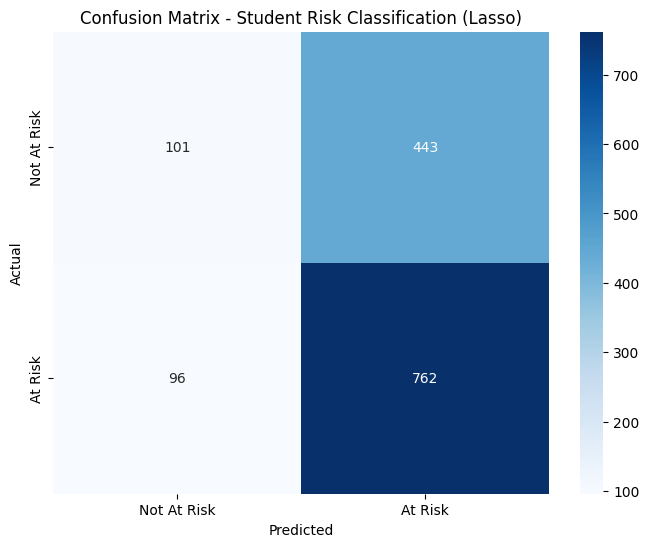

In [80]:
cm = confusion_matrix(test_df['Risk_Binary'], test_df['Pred_Risk_Binary'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not At Risk', 'At Risk'],
            yticklabels=['Not At Risk', 'At Risk'])
plt.ylabel('Actual') 
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Student Risk Classification (Lasso)')
plt.show()

In [81]:
poly_feature_names = poly_risk.get_feature_names_out(risk_features)
feature_importance_poly = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coefficient': risk_model.coef_
})
feature_importance_poly['Abs_Coefficient'] = np.abs(feature_importance_poly['Coefficient'])
feature_importance_poly = feature_importance_poly.sort_values('Abs_Coefficient', ascending=False)

non_zero_features = feature_importance_poly[feature_importance_poly['Coefficient'] != 0]
print(f"Number of non-zero features: {len(non_zero_features)}")
print("\nTop 20 Polynomial Features:")
print(feature_importance_poly.head(20))

Number of non-zero features: 31

Top 20 Polynomial Features:
                                                 Feature  Coefficient  \
40911         Pred_Stress Pred_Anxiety^2 Pred_Depression     0.003881   
40913                      Pred_Stress Pred_Depression^3     0.002730   
40907                       Pred_Stress^2 Pred_Anxiety^2     0.001696   
36360  Extracurricular_Involvement Semester_Credit_Lo...    -0.000685   
40904                                      Pred_Stress^4     0.000685   
17194                Sleep_Quality^2 Physical_Activity^2    -0.000316   
25969                                   Social_Support^4     0.000223   
40910                         Pred_Stress Pred_Anxiety^3     0.000218   
28269                                    Substance_Use^4    -0.000211   
34949                     Financial_Stress^3 Pred_Stress     0.000211   
32464                  Family_History Financial_Stress^3    -0.000197   
34935     Financial_Stress^3 Extracurricular_Involvement    -0.

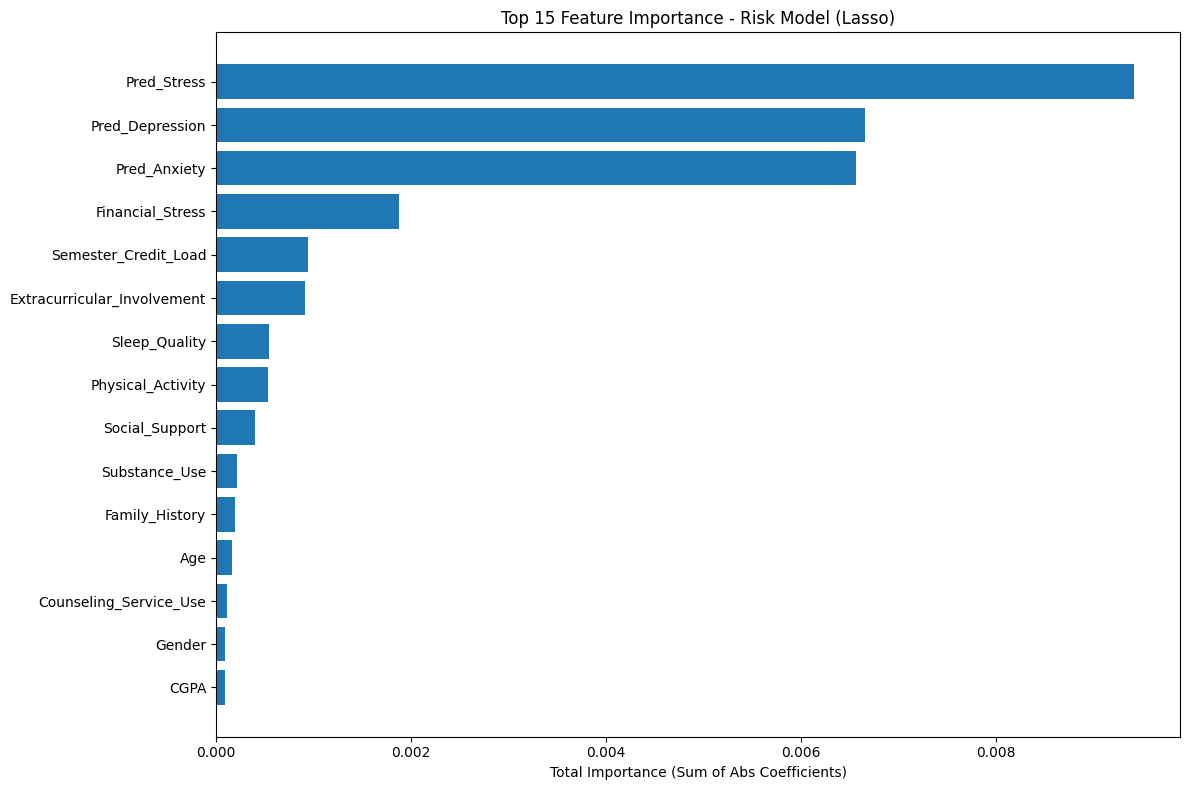

In [82]:
original_importance = {}
for feature in risk_features:
    mask = feature_importance_poly['Feature'].str.contains(feature, regex=False)
    original_importance[feature] = feature_importance_poly.loc[mask, 'Abs_Coefficient'].sum()

original_importance_df = pd.DataFrame({
    'Feature': list(original_importance.keys()),
    'Total_Importance': list(original_importance.values())
}).sort_values('Total_Importance', ascending=False)

plt.figure(figsize=(12, 8))
top_features = original_importance_df.head(15)
plt.barh(top_features['Feature'], top_features['Total_Importance'])
plt.xlabel('Total Importance (Sum of Abs Coefficients)')
plt.title('Top 15 Feature Importance - Risk Model (Lasso)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()